True

In [3]:
import sys
if not 'geopandas' in sys.modules:
  !pip install geopandas 
import geopandas as gpd 
import pandas as pd
import numpy as np
import math
from shapely.geometry import LineString

     |████████████████████████████████| 1.0MB 12.0MB/s 
     |████████████████████████████████| 6.5MB 28.5MB/s 
     |████████████████████████████████| 14.8MB 322kB/s 


In [10]:
%cd /content/drive/MyDrive/Colab\ Notebooks/geospatial\ statistical\ analysis 

/content/drive/MyDrive/Colab Notebooks/geospatial statistical analysis


In [11]:
ls

 AccessibleDestinations/  'GSA kaggle notes.ipynb'
 crimes-in-boston/         NYS_Civil_Boundaries_SHP/
 DEC_roadstrails/          PhillyHealth_Air_Monitoring_Stations/
 DECSLFStands/             purple_martin.csv
 ghana/                    toxic_release_pennsylvania/


##Step 1. Different methods to wrangle and visualize geospatial data, or data with a geographic location.

In [247]:
# shapefile is the most common file type in geospatial statistical analysis
# Read in the data
full_data = gpd.read_file("DECSLFStands/DECSLFStands.shp")

# View the first five rows of the data
full_data.head()

,OBJECTID,UNIT,FACILITY,FACILITY_N,COMPART,DIG_YEAR,DESCRIP,DIG_ACRES,UPDATE_,STAND_NO,TREATMENT_,FINAL_HARV,SHAPE_AREA,SHAPE_LEN,ROW_ID,STAND_UID,TREE_TYPE1,BA1_PCT,TREE_TYPE2,BA2_PCT,TREE_TYPE3,BA3_PCT,CALC_FT,OBSERVED_F,MGT_CLASS,STATUS,STAND_DIA,SIZE_CLASS,TOPO,DRAINAGE,YEAR_LAST_,STAND_BASA,LAST_INVEN,AGE_ARRANG,SITE_CLASS,YEAR_PLANT,geometry
0,30683673,STEUBEN 06,URBANA STATE FOREST,1770,1,2010,None,57.981214,2015-12-29,2.2,None,N,234641.647856,3426.816026,27334,8.270601e+09,"Maple, Sugar",28,"Maple, Red",25,"Oak, Red",17,Other,Transition Hard (NH-Oak),Timber,Natural Forest,PT,C,Gentle (6 - 20%),Good,None,71,2015,Uneven Aged,3.0,None,"POLYGON ((314546.402 4704810.295, 314549.709 4..."
1,30683674,HERKIMER 02,STEUBEN HILL STATE FOREST,1551,1,1995,None,3.244071,2015-03-25,34.3,None,N,13128.291316,580.473314,35693,6.440201e+09,"Maple, Red",64,"Larch, European",36,Null,0,Misc Species (Pure),European Larch,Timber,Plantation,SST,D,Gentle (6 - 20%),Good,None,110,2015,Even Aged,3.0,None,"POLYGON ((495651.281 4770088.500, 495539.281 4..."
2,30683675,HERKIMER 02,STEUBEN HILL STATE FOREST,1551,1,1995,None,3.173221,2015-03-25,34.1,None,N,12841.569836,624.882823,35692,6.440201e+09,"Larch, European",48,"Ash, White",24,"Maple, Sugar",19,Bucket Mixes,European Larch,Timber,Plantation,MST,D,Gentle (6 - 20%),Good,None,210,2015,Even Aged,3.0,None,"POLYGON ((496736.125 4770318.500, 496715.844 4..."
3,30683676,STEUBEN 06,URBANA STATE FOREST,1770,1,2010,None,21.078547,2015-12-29,2.3,None,N,85301.854835,2838.635803,27335,8.270601e+09,"Ash, White",41,"Maple, Sugar",19,"Oak, Red",17,Other,Northern Hardwood,Timber,Natural Forest,PT,C,Gentle (6 - 20%),Good,None,140,2015,Even Aged,1.0,None,"MULTIPOLYGON (((314794.063 4704989.000, 314794..."
4,30683677,SCHOHARIE 03,BURNT-ROSSMAN HILLS STATE FOREST,1740,2,2007,None,10.585702,2015-06-09,10.1,None,N,42838.816209,1646.881685,31737,4.060302e+09,"Pine, Red",53,"Spruce, Norway",33,"Maple, Red",7,Red Pine-Plt,Red Pine - Spruce,Timber,Plantation,SST,D,Flat (0 - 5%),Poor,1989-01-01,196,2016,Even Aged,2.0,1933-01-01,"POLYGON ((539896.156 4708523.881, 539917.237 4..."


In [ ]:
type(full_data) #geodataframe object is a pandas dataframe

geopandas.geodataframe.GeoDataFrame

In [ ]:
'''Indexing a DataFrame returns a reference to the initial DataFrame.
Thus, use the copy if you want to make sure the initial DataFrame shouldn't change.
'''
data = full_data.loc[:, ["STATUS", "geometry"]].copy()

In [ ]:
# How many lands of each type are there?
data.STATUS.value_counts()

Natural Forest                       26463
Plantation                           13516
Natural Forest (Seedling/Sapling)     1933
Wetlands (Open)                       1281
Wetlands (Alder)                      1273
Other                                 1228
Forested Wetlands                     1003
Brushy Fields                          837
Ponds                                  620
Null                                   595
Plantation (Seedling/Sapling)          409
Grasslands                             314
Field 90%+ Plantable                    82
Wetlands Impounded                      56
Field 75 - 90% Plantable                21
Field 50 - 75% Plantable                 9
Name: STATUS, dtype: int64

In [ ]:
# Select lands that fall under the 'Wetlands (Open)' or 'Wetlands (Alder)' category
Wetlands = data.loc[data.STATUS.isin(['Wetlands (Open)', 'Wetlands (Alder)'])].copy()
Wetlands.head()

,STATUS,geometry
17,Wetlands (Alder),"MULTIPOLYGON (((389155.036 4723953.346, 389166..."
18,Wetlands (Open),"POLYGON ((454998.938 4828417.497, 455002.907 4..."
19,Wetlands (Open),"MULTIPOLYGON (((499408.655 4925879.387, 499412..."
28,Wetlands (Open),"POLYGON ((497158.370 4925405.431, 497148.089 4..."
32,Wetlands (Open),"POLYGON ((498284.165 4925624.708, 498279.828 4..."


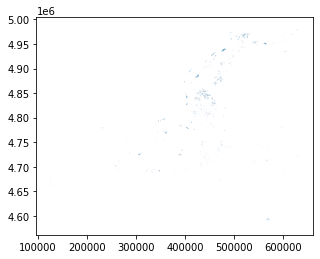

In [ ]:
Wetlands.plot()

In [ ]:
# While 'geometry' column can contain a variety of different datatypes, each entry will typically be a Point, LineString, or Polygon.

Wetlands.geometry.head()

17    MULTIPOLYGON (((389155.036 4723953.346, 389166...
18    POLYGON ((454998.938 4828417.497, 455002.907 4...
19    MULTIPOLYGON (((499408.655 4925879.387, 499412...
28    POLYGON ((497158.370 4925405.431, 497148.089 4...
32    POLYGON ((498284.165 4925624.708, 498279.828 4...
Name: geometry, dtype: geometry

Create three more GeoDataFrames, containing campsite locations (Point), foot trails (LineString), and county boundaries (Polygon).

In [ ]:
# Campsites in New York state (Point)
point_data = gpd.read_file("AccessibleDestinations/AccessibleDestinations.shp")
campsites = point_data.loc[point_data.FEATURE=='PRIMITIVE CAMPSITE'].copy()

# Foot trails in New York state (LineString)
roads_trails = gpd.read_file("DEC_roadstrails/DECroadstrails.shp")
trails = roads_trails.loc[roads_trails.ASSET=='FOOT TRAIL'].copy()

# County boundaries in New York state (Polygon)
counties = gpd.read_file("NYS_Civil_Boundaries_SHP/State_Shoreline.shp")


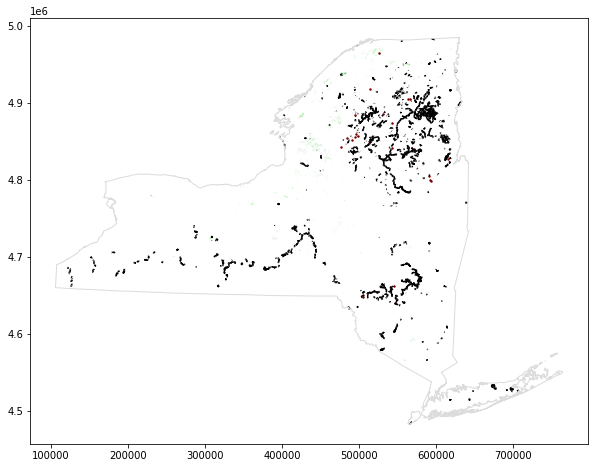

In [ ]:
'''The plot() method takes as (optional) input several parameters that can be used to customize the appearance. 
Most importantly, setting a value for ax ensures that all of the information is plotted on the same map'''
# Define a base map with county boundaries
ax = counties.plot(figsize=(10,10), color='none', edgecolor='gainsboro', zorder=3)

# Add Wetlands, campsites, and foot trails to the base map
Wetlands.plot(color='lightgreen', ax=ax)
campsites.plot(color='maroon', markersize=2, ax=ax)
trails.plot(color='black', markersize=1, ax=ax)

##Step 2. Coordinate Reference Systems

The maps portray the surface of the earth in two dimensions. 
Map projections can't be 100% accurate.

The equal-area projections preserve area. This is a good choice, if you'd like to calculate the area of a country or city, for example.

The equidistant projections preserve distance. This would be a good choice for calculating flight distance.

In [ ]:
# When we create a GeoDataFrame from a shapefile, the CRS is already imported for us
regions = gpd.read_file("ghana/Regions/Map_of_Regions_in_Ghana.shp")
print(regions.crs)

epsg:32630


This GeoDataFrame uses EPSG 32630, which is more commonly called the "Mercator" projection. This projection preserves angles (making it useful for sea navigation) and slightly distorts area.

However, when creating a GeoDataFrame from a CSV file, we have to set the CRS. EPSG 4326 corresponds to coordinates in latitude and longitude.

In [ ]:
# Create a DataFrame with health facilities in Ghana
facilities_df = pd.read_csv("ghana/health_facilities.csv")

# Convert the DataFrame to a GeoDataFrame, gpd.points_from_xy() function creates Point objects from the latitude and longitude columns.
facilities = gpd.GeoDataFrame(facilities_df, geometry=gpd.points_from_xy(facilities_df.Longitude, facilities_df.Latitude))

# Set the coordinate reference system (CRS) to EPSG 4326
facilities.crs = {'init': 'epsg:4326'}

# View the first five rows of the GeoDataFrame
facilities.head()

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,Region,District,FacilityName,Type,Town,Ownership,Latitude,Longitude,geometry
0,Ashanti,Offinso North,A.M.E Zion Clinic,Clinic,Afrancho,CHAG,7.40801,-1.96317,POINT (-1.96317 7.40801)
1,Ashanti,Bekwai Municipal,Abenkyiman Clinic,Clinic,Anwiankwanta,Private,6.46312,-1.58592,POINT (-1.58592 6.46312)
2,Ashanti,Adansi North,Aboabo Health Centre,Health Centre,Aboabo No 2,Government,6.22393,-1.34982,POINT (-1.34982 6.22393)
3,Ashanti,Afigya-Kwabre,Aboabogya Health Centre,Health Centre,Aboabogya,Government,6.84177,-1.61098,POINT (-1.61098 6.84177)
4,Ashanti,Kwabre,Aboaso Health Centre,Health Centre,Aboaso,Government,6.84177,-1.61098,POINT (-1.61098 6.84177)


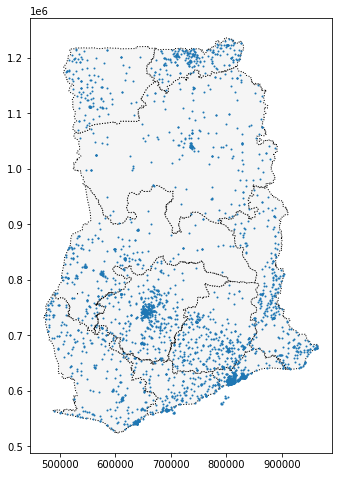

In [ ]:
# Create a map
ax = regions.plot(figsize=(8,8), color='whitesmoke', linestyle=':', edgecolor='black')
facilities.to_crs(epsg=32630).plot(markersize=1, ax=ax) # re-projecting: changing the CRS

In [ ]:
# Get the x-coordinate of each point
facilities.geometry.x.head()

0   -1.96317
1   -1.58592
2   -1.34982
3   -1.61098
4   -1.61098
dtype: float64

In [ ]:
# Calculate the area (in square meters) of each polygon in the GeoDataFrame 
regions.loc[:, "AREA"] = regions.geometry.area / 10**6

print("Area of Ghana: {} square kilometers".format(regions.AREA.sum()))
print("CRS:", regions.crs)
regions.head()

Area of Ghana: 239584.5760055668 square kilometers
CRS: epsg:32630


,Region,geometry,AREA
0,Ashanti,"POLYGON ((686446.075 842986.894, 686666.193 84...",24379.017777
1,Brong Ahafo,"POLYGON ((549970.457 968447.094, 550073.003 96...",40098.168231
2,Central,"POLYGON ((603176.584 695877.238, 603248.424 69...",9665.626760
3,Eastern,"POLYGON ((807307.254 797910.553, 807311.908 79...",18987.625847
4,Greater Accra,"POLYGON ((858081.638 676424.913, 858113.115 67...",3706.511145


 since the CRS of the regions GeoDataFrame is set to EPSG 32630 (a "Mercator" projection), the area calculation is slightly less accurate than if we had used an equal-area projection like "Africa Albers Equal Area Conic".

###Track bird migration to South America.

In [ ]:
birds_df = pd.read_csv("purple_martin.csv", parse_dates=['timestamp'])
print("There are {} different birds in the dataset.".format(birds_df["tag-local-identifier"].nunique()))
birds_df.columns

There are 11 different birds in the dataset.


Index(['timestamp', 'location-long', 'location-lat', 'tag-local-identifier'], dtype='object')

In [ ]:
birds = gpd.GeoDataFrame(birds_df, geometry=gpd.points_from_xy(birds_df['location-long'], birds_df['location-lat']))
birds.crs = {'init': 'epsg:4326'}

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [ ]:
# Load a GeoDataFrame with country boundaries in North/South America, print the first 5 rows
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
americas = world.loc[world['continent'].isin(['North America', 'South America'])]

In [ ]:
# GeoDataFrame showing path for each bird, LineString() method to create a 
# LineString object from a list of Point objects.
# When we reset the index, the old index is added as a column, and a new sequential index is used:
path_df = birds.groupby("tag-local-identifier")['geometry'].apply(list).apply(lambda x: LineString(x)).reset_index()
path_gdf = gpd.GeoDataFrame(path_df, geometry=path_df.geometry)
path_gdf.crs = {'init' :'epsg:4326'}

# GeoDataFrame showing starting/ending point for each bird
start_df = birds.groupby("tag-local-identifier")['geometry'].apply(list).apply(lambda x: x[0]).reset_index()
start_gdf = gpd.GeoDataFrame(start_df, geometry=start_df.geometry)
start_gdf.crs = {'init' :'epsg:4326'}

end_df = birds.groupby("tag-local-identifier")['geometry'].apply(list).apply(lambda x: x[-1]).reset_index()
end_gdf = gpd.GeoDataFrame(end_df, geometry=end_df.geometry)
end_gdf.crs = {'init' :'epsg:4326'}

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://

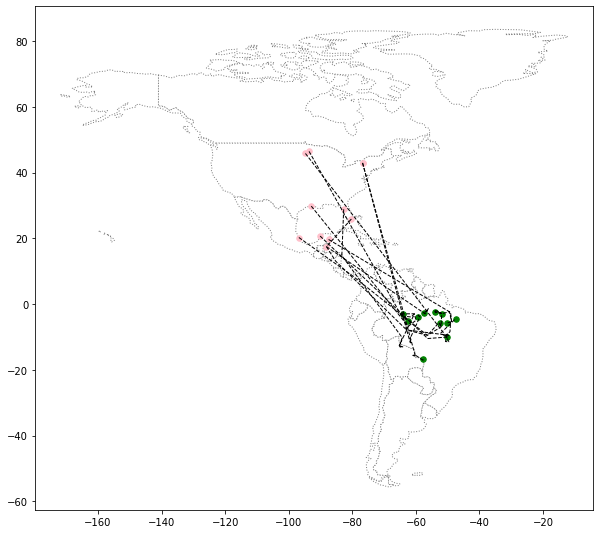

In [ ]:
# Define a base map with americas
ax = americas.plot(figsize=(10,10), color='white', edgecolor='gray', linestyle=':')

start_gdf.plot(color='pink', markersize=30, ax=ax)
end_gdf.plot(color='green', markersize=30, ax=ax)
path_gdf.plot(color='black', markersize=1, ax=ax, zorder = 1, linestyle='--', linewidth = 1)

##Step 3. Interactive Maps

In [ ]:
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster

In [ ]:
"""Create a map 
location sets the initial center of the map. We use the latitude (42.32° N) and longitude (-71.0589° E) of the city of Boston.
tiles changes the styling of the map; in this case, we choose the OpenStreetMap style..
zoom_start sets the initial level of zoom of the map, where higher values zoom in closer to the map."""

m_1 = folium.Map(location=[42.32,-71.0589], tiles='openstreetmap', zoom_start=10)
# Display the map
m_1

In [13]:
crimes = pd.read_csv("crimes-in-boston/crime.csv", encoding='windows-1252')
crimes.head(5)


,ï»¿INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
0,I182070945,619,Larceny,LARCENY ALL OTHERS,D14,808,NaN,2018/9/2 13:00,2018,9,Sunday,13,Part One,LINCOLN ST,42.357791,-71.139371,"(42.35779134, -71.13937053)"
1,I182070943,1402,Vandalism,VANDALISM,C11,347,NaN,2018/8/21 0:00,2018,8,Tuesday,0,Part Two,HECLA ST,42.306821,-71.060300,"(42.30682138, -71.06030035)"
2,I182070941,3410,Towed,TOWED MOTOR VEHICLE,D4,151,NaN,2018/9/3 19:27,2018,9,Monday,19,Part Three,CAZENOVE ST,42.346589,-71.072429,"(42.34658879, -71.07242943)"
3,I182070940,3114,Investigate Property,INVESTIGATE PROPERTY,D4,272,NaN,2018/9/3 21:16,2018,9,Monday,21,Part Three,NEWCOMB ST,42.334182,-71.078664,"(42.33418175, -71.07866441)"
4,I182070938,3114,Investigate Property,INVESTIGATE PROPERTY,B3,421,NaN,2018/9/3 21:05,2018,9,Monday,21,Part Three,DELHI ST,42.275365,-71.090361,"(42.27536542, -71.09036101)"


In [ ]:
daytime_robberies = crimes[((crimes.OFFENSE_CODE_GROUP == 'Robbery') & \
                            (crimes.HOUR.isin(range(9,18))))]

daytime_robberies = daytime_robberies[daytime_robberies['Lat'].apply(lambda x: not math.isnan(x)) & (daytime_robberies['Lat'].apply(lambda x: not math.isnan(x)))]

In [ ]:
crimes = crimes[crimes['Lat'].apply(lambda x: not math.isnan(x)) & (crimes['Lat'].apply(lambda x: not math.isnan(x)))].reset_index()

In [ ]:
# Create a map
m_2 = folium.Map(location=[42.32,-71.0589], tiles='cartodbpositron', zoom_start=13)

# Add points to the map
for idx, row in daytime_robberies.iterrows():
  if not math.isnan(float(row['Lat'])) and not math.isnan(float(row['Long'])):
    Marker([row['Lat'], row['Long']]).add_to(m_2)

# Display the map
m_2

In [ ]:
# Create the map
m_3 = folium.Map(location=[42.32,-71.0589], tiles='cartodbpositron', zoom_start=13)

# Add points to the map
mc = MarkerCluster()
for idx, row in daytime_robberies.iterrows():
    if not math.isnan(row['Long']) and not math.isnan(row['Lat']):
        mc.add_child(Marker([row['Lat'], row['Long']]))
m_3.add_child(mc)

# Display the map
m_3

In [ ]:
# Create a base map
m_4 = folium.Map(location=[42.32,-71.0589], tiles='cartodbpositron', zoom_start=13)

def color_producer(val):
    if val <= 12:
        return 'forestgreen'
    else:
        return 'darkred'

def radius_producer(val): 
    if val == 'Y':
        return 100
    else:
        return 20

# Add a bubble map to the base map
for i in range(0,len(daytime_robberies)):
    Circle(
        location=[daytime_robberies.iloc[i]['Lat'], daytime_robberies.iloc[i]['Long']],
        radius=radius_producer(daytime_robberies.iloc[i]['SHOOTING']),
        color=color_producer(daytime_robberies.iloc[i]['HOUR'])).add_to(m_4)

# Display the map
m_4

In [ ]:

daytime_robberies


,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
62,I182070865,301,Robbery,ROBBERY - STREET,NaN,,NaN,2018-09-03 15:54:00,2018,9,Monday,15,Part One,NaN,42.315809,-71.098290,"(42.31580852, -71.09829029)"
299,I182070598,311,Robbery,ROBBERY - COMMERCIAL,A15,60,NaN,2018-09-02 17:15:00,2018,9,Sunday,17,Part One,RUTHERFORD AVE,42.371673,-71.063264,"(42.37167264, -71.06326413)"
527,I182070342,381,Robbery,ROBBERY - CAR JACKING,E18,490,NaN,2018-09-01 17:05:00,2018,9,Saturday,17,Part One,CUMMINS HWY,42.276453,-71.112980,"(42.27645319, -71.11297971)"
562,I182070309,361,Robbery,ROBBERY - OTHER,D4,151,NaN,2018-09-01 15:00:00,2018,9,Saturday,15,Part One,BERKELEY ST,42.346055,-71.070507,"(42.34605510, -71.07050669)"
1127,I182069693,301,Robbery,ROBBERY - STREET,A1,74,NaN,2018-08-30 15:24:00,2018,8,Thursday,15,Part One,BULFINCH PL,42.362191,-71.062238,"(42.36219081, -71.06223802)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317663,I152050846,361,Robbery,ROBBERY - OTHER,E18,485,NaN,2015-06-19 15:41:00,2015,6,Friday,15,Part One,RIVER ST,42.264305,-71.100613,"(42.26430493, -71.10061293)"
317935,I152050517,301,Robbery,ROBBERY - STREET,A1,116,NaN,2015-06-18 12:00:46,2015,6,Thursday,12,Part One,LINCOLN ST,42.351318,-71.058384,"(42.35131763, -71.05838367)"
318169,I152050226,311,Robbery,ROBBERY - COMMERCIAL,E18,503,NaN,2015-06-17 15:40:00,2015,6,Wednesday,15,Part One,AMERICAN LEGION HWY,42.283147,-71.113742,"(42.28314714, -71.11374152)"
318732,I152039327-00,361,Robbery,ROBBERY - OTHER,A1,119,NaN,2016-06-26 12:50:00,2016,6,Sunday,12,Part One,PARK ST,42.356502,-71.062000,"(42.35650174, -71.06199960)"


In [ ]:
# Create a base map
m_5 = folium.Map(location=[42.32,-71.0589], tiles='cartodbpositron', zoom_start=12)

HeatMap(data = [crimes['Lat'].tolist(), crimes['Long'].tolist()], radius=10).add_to(m_5)

# Display the map
m_5

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
plot_dict = crimes.DISTRICT.value_counts()
plot_dict.head()

B2     46207
C11    40875
D4     38396
B3     33701
A1     32301
Name: DISTRICT, dtype: int64

Geocoding
Geocoding is the process of converting the name of a place or an address to a location on a map. 



In [ ]:
from geopandas.tools import geocode

In [ ]:
result = geocode("The Great Pyramid of Giza", provider="nominatim")
result

/usr/local/lib/python3.7/dist-packages/geopy/geocoders/osm.py:143: UserWarning: Using Nominatim with the default "geopy/1.17.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  UserWarning


,geometry,address
0,POINT (31.13422 29.97916),"هرم خوفو, شارع ابو الهول السياحي, نزلة البطران..."


In [ ]:
point = result.geometry.iloc[0]
print("Latitude:", point.y)
print("Longitude:", point.x)

Latitude: 29.97915995
Longitude: 31.134215650388754


###Attribute join
pd.DataFrame.join() : combine information from multiple DataFrames with a shared index. 

We refer to this way of joining data (by simpling matching values in the index) as an attribute join.

In [ ]:
europe = europe_boundaries.merge(europe_stats, on="name")
europe.head()

Use a spatial join to combine GeoDataFrames based on the spatial relationship between the objects in the "geometry" columns.

(match each university to its corresponding country)

We do this with gpd.sjoin()

 ## Proximity analysis. 
 In particular, you'll learn how to do such things as:

measure the distance between points on a map, and
select all points within some radius of a feature.

In [15]:
releases = gpd.read_file("toxic_release_pennsylvania/toxic_release_pennsylvania.shp") 
stations = gpd.read_file("PhillyHealth_Air_Monitoring_Stations/PhillyHealth_Air_Monitoring_Stations.shp")

DriverError: ignored

In [ ]:
# check the CRS to see which units it uses
print(stations.crs)
print(releases.crs)
# https://epsg.io/2272

In [14]:
# Measure distance from release to each station
distances = stations.geometry.distance(recent_release.geometry)

 AccessibleDestinations/  'GSA kaggle notes.ipynb'
 crimes-in-boston/         NYS_Civil_Boundaries_SHP/
 DEC_roadstrails/          PhillyHealth_Air_Monitoring_Stations/
 DECSLFStands/             purple_martin.csv
 ghana/                    toxic_release_pennsylvania/


In [ ]:
print('Closest monitoring station ({} feet):'.format(distances.min()))
print(stations.iloc[distances.idxmin()][["ADDRESS", "LATITUDE", "LONGITUDE"]])

Understand all points on a map that are some radius away from a point.

We use folium.GeoJson() to plot each polygon on a map. 

Note that since folium requires coordinates in latitude and longitude, 

we have to convert the CRS to EPSG 4326 before plotting

In [ ]:
two_mile_buffer = stations.geometry.buffer(2*5280)
# Create map with release incidents and monitoring stations
m = folium.Map(location=[39.9526,-75.1652], zoom_start=11)
HeatMap(data=releases[['LATITUDE', 'LONGITUDE']], radius=15).add_to(m)
for idx, row in stations.iterrows():
    Marker([row['LATITUDE'], row['LONGITUDE']]).add_to(m)
    
# Plot each polygon on the map
GeoJson(two_mile_buffer.to_crs(epsg=4326)).add_to(m)

# Show the map
m